In [1]:
%matplotlib inline

import numpy as np
import scipy.stats
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import warnings

from IPython.display import display, Markdown

def custom_warning_format(message, category, *_, **__):
    return f'{category.__name__}: {message}\n'

def nanpearsonr(x, y):
    """Compute Pearson R correlation coefficient excluding NaN values"""
    keep = np.logical_and(np.isfinite(x), np.isfinite(y))
    
    # scipy.stats.pearsons raises ValueError if there's fewer than 2 values in the arrays
    if np.count_nonzero(keep) < 2:
        return np.nan
    
    with warnings.catch_warnings():
        warnings.formatwarning = custom_warning_format
        warnings.simplefilter('always', scipy.stats.PearsonRConstantInputWarning)
        warnings.simplefilter('always', scipy.stats.PearsonRNearConstantInputWarning)
        r, p_value = scipy.stats.pearsonr(x[keep], y[keep])
    return r

### Why having correlation and per-model correlation?

- Two models for the same target sequence
- The residue scores they predict are quite off if we look at the single residues
- However, when we average the local scores to get a global score, the predictions are not bad (would still rank the models correctly)

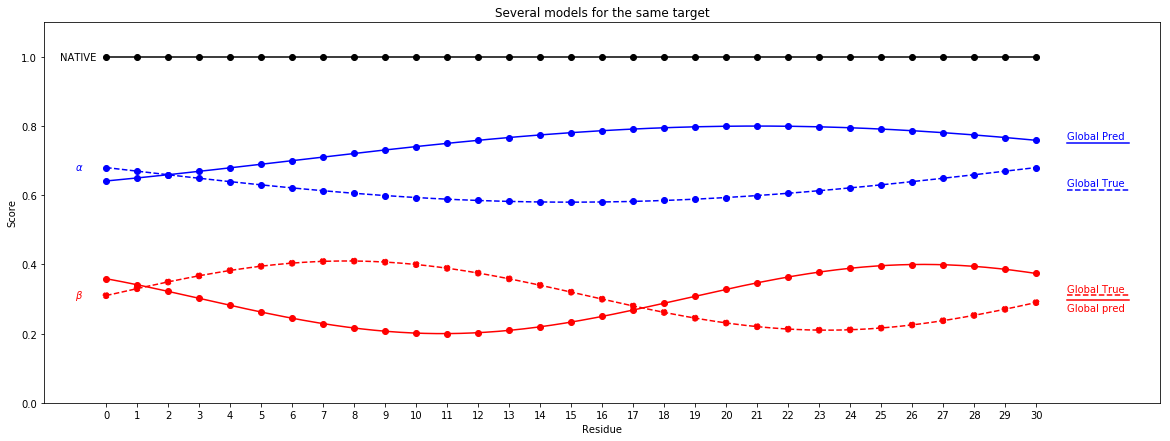

In [2]:
length = 31
x = np.linspace(0, length-1, num=1000)
sequence = np.arange(0., length)

model_native = lambda seq: np.ones_like(seq)

model_beta_true = lambda seq: .31 + .1 * np.sin(seq * (2 * np.pi / length))
model_beta_pred = lambda seq: .3  + .1 * np.sin(seq * (2 * np.pi / length) + .8 * np.pi)

model_alpha_true = lambda seq: .68 - .1 * np.sin(seq * (np.pi / (length - 1)))
model_alpha_pred = lambda seq: .7  - .1 * np.sin(seq * (np.pi / (length - 1)) + .8 * np.pi)

fig, ax = plt.subplots(1, 1, figsize=(20, 7))

ax.set_title('Several models for the same target')
ax.set_ylabel('Score')
ax.set_xlabel('Residue')

ax.plot(x, model_native(x), c='k')
ax.scatter(sequence, model_native(sequence), c='k')
ax.text(-1.5, 1, 'NATIVE', verticalalignment='center', color='k')

ax.plot(x, model_alpha_true(x), c='b', linestyle='--')
ax.plot([length, length+2], 2 * [model_alpha_true(x).mean()], c='b', linestyle='--')
ax.text(length, model_alpha_true(x).mean()+.01, 'Global True', color='b')
ax.scatter(sequence, model_alpha_true(sequence), c='b')
ax.text(-1, model_alpha_true(0), r'$\alpha$', verticalalignment='center', color='b')

ax.plot(x, model_alpha_pred(x), c='b')
ax.plot([length, length+2], 2 * [model_alpha_pred(x).mean()], c='b')
ax.text(length, model_alpha_pred(x).mean()+.01, 'Global Pred', color='b')
ax.scatter(sequence, model_alpha_pred(sequence), c='b')

ax.plot(x, model_beta_true(x), c='r', linestyle='--')
ax.plot([length, length+2], 2 * [model_beta_true(x).mean()], c='r', linestyle='--')
ax.text(length, model_beta_true(x).mean()+.01, 'Global True', color='r')
ax.scatter(sequence, model_beta_true(sequence), c='r', linestyle='--')
ax.text(-1, model_beta_true(0), r'$\beta$', verticalalignment='center', color='r')

ax.plot(x, model_beta_pred(x), c='r')
ax.plot([length, length+2], 2 * [model_beta_pred(x).mean()], c='r')
ax.text(length, model_beta_pred(x).mean()-.01, 'Global pred', color='r', verticalalignment='top')
ax.scatter(sequence, model_beta_pred(sequence), c='r')

ax.set_ylim([0, 1.1])
ax.set_xlim([-2, length+3])
ax.set_xticks(sequence);

- If we put all local scores in a scatter plot and compute the Pearson correlation coefficient between all of them we get 0.84 which is quite good
- However, if we compute the correlation coefficient at the model level and then average across the models we get -0.67 which is quite bad

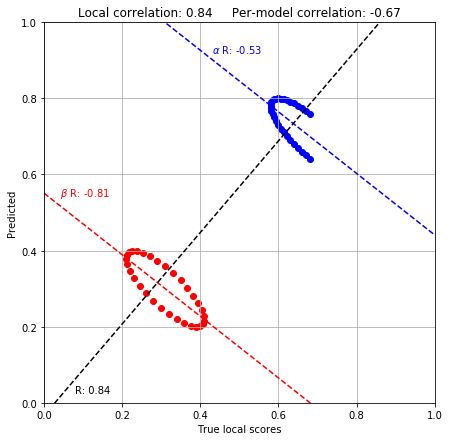

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.scatter(model_alpha_true(sequence), model_alpha_pred(sequence), c='b')
slope, intercept, pearsonr_alpha, _, _ = scipy.stats.linregress(
    model_alpha_true(sequence),
    model_alpha_pred(sequence)
)
ax.plot([0, 1], [intercept, slope + intercept], c='b', linestyle='--')
ax.text(.43, slope * .41 + intercept, f'$\\alpha$ R: {pearsonr_alpha:.2f}', color='b')

ax.scatter(model_beta_true(sequence), model_beta_pred(sequence), c='r')
slope, intercept, pearsonr_beta, _, _ = scipy.stats.linregress(
    model_beta_true(sequence),
    model_beta_pred(sequence)
)
ax.plot([0, 1], [intercept, slope + intercept], c='r', linestyle='--')
ax.text(.04, slope * .01 + intercept, f'$\\beta$ R: {pearsonr_beta:.2f}', color='r')

slope, intercept, pearsonr, _, _ = scipy.stats.linregress(
    np.concatenate((model_alpha_true(sequence), model_beta_true(sequence))),
    np.concatenate((model_alpha_pred(sequence), model_beta_pred(sequence)))
)
ax.plot([0, 1], [intercept, slope + intercept], c='k', linestyle='--')
ax.text(.08, slope * .05 + intercept, f'R: {pearsonr:.2f}', color='k')

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('True local scores')
ax.set_ylabel('Predicted')
ax.set_title(f'Local correlation: {pearsonr:.2f}     Per-model correlation: {np.mean([pearsonr_alpha, pearsonr_beta]):.2f}')
ax.grid()

## Example data

In [4]:
df = pd.concat([
    pd.DataFrame({
            ('Score', 'Predicted'): [.9, .8, .9, .3, .1,   .2, .5, .7, .8],
            ('Score', 'Real'):      [ 1,  1,  1, .3, .2, None, .6, .7, .8],
            ('Present', 'Native'): [ True,  True,  True] * 3,
            ('Present', 'Model'):  [ True,  True,  True, True, True, False, True, True, True],
        },
        index=pd.MultiIndex.from_product([['NATIVE', 'alpha', 'beta'], [0, 1, 2]], names=['Model', 'Residue'])
    ),
    pd.DataFrame({
            ('Score', 'Predicted'): [.2, .8, .9, .7,   .3, .3, .2, .6, .4,   .8, .3, .2, .5,   .2,   .1],
            ('Score', 'Real'):      [ 1,  1,  1,  1, None, .7, .8, .7, .6, None, .1, .3, .5, None, None],
            ('Present', 'Native'): [ True, True, True, True, False] * 3,
            ('Present', 'Model'):  [ True, True, True, True, False, True, True, True, True, True, True, True, True, False, True ],
        },
        index=pd.MultiIndex.from_product([['NATIVE', 'alpha', 'beta'], [0, 1, 2, 3, 4]], names=['Model', 'Residue'])
    )],
    axis='index',
    keys=['T001', 'T002'],
    names=['Target']
)
df.style \
    .applymap({False: 'color: red', True: 'color: green'}.__getitem__, subset='Present') \
    .applymap(lambda v: 'color: red' if np.isnan(v) else '', subset=[('Score', 'Real')]) \
    .format('✗✔'.__getitem__, subset='Present') \
    .format(lambda s: '/' if np.isnan(s) else s, subset='Score')

## Local scores

### Local correlation
Just take the predicted and true values for all local scores and compute R.

In [5]:
r_local = nanpearsonr(df.Score.Real, df.Score.Predicted)
print('Local correlation:', r_local)

Local correlation: 0.6910449544637652


### Per-model correlation
For each (target, model), compute R between the real and predicted scores of its residues. Then average the R values obtained for every (target, model).

```AVG ( Pearson(predicted,true) GROUPBY(Target, Model) )```

- In this way, the same importance is given to all (target, model) pairs, regardless of the length of their sequence.
- For example, let's say that in the dataset there is a target of 400+ residues which is very hard to predict (e.g. because there's few examples of long proteins in the dataset).
  Also, let's say that the rest of the targets are shorter and easier to predict.
  If we compute R on all residues (Local Correlation), we end up with a very low R because of that single hard-to-predict model with many residues.
  If we compute a single R for every (target, model) pair and average them, the lenghts of the sequences don't count anymore.
- However, it is still possible that an easy-to-predict target with 100s models shadows an hard-to-predict target with few models.

Here we show how grouping scores by (target, model) pairs works and the R coefficient that are computed.

In [6]:
groups = df.groupby(axis='index', level=['Target', 'Model'])

for name, df_model in groups:
    display(df_model.Score.round(3))
    display(Markdown(f'Per model correlation: {nanpearsonr(df_model.Score.Real, df_model.Score.Predicted)}'))

Predicted  Real
Target Model  Residue                 
T001   NATIVE 0              0.9   1.0
              1              0.8   1.0
              2              0.9   1.0

Per model correlation: nan

Predicted  Real
Target Model Residue                 
T001   alpha 0              0.3   0.3
             1              0.1   0.2
             2              0.2   NaN

Per model correlation: 1.0

Predicted  Real
Target Model Residue                 
T001   beta  0              0.5   0.6
             1              0.7   0.7
             2              0.8   0.8

Per model correlation: 0.9819805060619656

Predicted  Real
Target Model  Residue                 
T002   NATIVE 0              0.2   1.0
              1              0.8   1.0
              2              0.9   1.0
              3              0.7   1.0
              4              0.3   NaN

Per model correlation: nan

Predicted  Real
Target Model Residue                 
T002   alpha 0              0.3   0.7
             1              0.2   0.8
             2              0.6   0.7
             3              0.4   0.6
             4              0.8   NaN

Per model correlation: -0.47809144373375767

Predicted  Real
Target Model Residue                 
T002   beta  0              0.3   0.1
             1              0.2   0.3
             2              0.5   0.5
             3              0.2   NaN
             4              0.1   NaN

Per model correlation: 0.6546536707079773

Here we show a summary of the groups above and the result of averaging their R coefficients.

In [7]:
r_per_model = groups \
    .apply(lambda df_model: nanpearsonr(df_model.Score.Real, df_model.Score.Predicted))
display(r_per_model.to_frame('R per model').round(3))

avg_r_per_model = r_per_model.mean(skipna=True)
print('Per model correlation:', avg_r_per_model)

R per model
Target Model              
T001   NATIVE          NaN
       alpha         1.000
       beta          0.982
T002   NATIVE          NaN
       alpha        -0.478
       beta          0.655

Per model correlation: 0.5396356832590463


### Per-residue-target correlation

At each location of a target sequence, consider all the real and predicted scores from all models and compute R. Then average the R values obtained for every location.

```AVG ( Pearson(predicted,true) GROUPBY(Target, Residue) )```

This is helpful to see if for a given target there is a part of the sequence that is easier/harder than the rest.

Here we show how grouping scores by (target, residue) pairs would work and the R coefficient that would be computed.

In [8]:
groups = df.groupby(axis='index', level=['Target', 'Residue'])

for name, df_residue_target in groups:
    display(df_residue_target.Score.round(3))
    display(Markdown(f'Per residue-target correlation: {nanpearsonr(df_residue_target.Score.Real, df_residue_target.Score.Predicted)}'))

Predicted  Real
Target Model  Residue                 
T001   NATIVE 0              0.9   1.0
       alpha  0              0.3   0.3
       beta   0              0.5   0.6

Per residue-target correlation: 0.9941916256019199

Predicted  Real
Target Model  Residue                 
T001   NATIVE 1              0.8   1.0
       alpha  1              0.1   0.2
       beta   1              0.7   0.7

Per residue-target correlation: 0.9694551971144154

Predicted  Real
Target Model  Residue                 
T001   NATIVE 2              0.9   1.0
       alpha  2              0.2   NaN
       beta   2              0.8   0.8

Per residue-target correlation: 1.0

Predicted  Real
Target Model  Residue                 
T002   NATIVE 0              0.2   1.0
       alpha  0              0.3   0.7
       beta   0              0.3   0.1

Per residue-target correlation: -0.7559289460184545

Predicted  Real
Target Model  Residue                 
T002   NATIVE 1              0.8   1.0
       alpha  1              0.2   0.8
       beta   1              0.2   0.3

Per residue-target correlation: 0.720576692122892

Predicted  Real
Target Model  Residue                 
T002   NATIVE 2              0.9   1.0
       alpha  2              0.6   0.7
       beta   2              0.5   0.5

Per residue-target correlation: 0.9862413826124555

Predicted  Real
Target Model  Residue                 
T002   NATIVE 3              0.7   1.0
       alpha  3              0.4   0.6
       beta   3              0.2   NaN

Per residue-target correlation: 1.0

Predicted  Real
Target Model  Residue                 
T002   NATIVE 4              0.3   NaN
       alpha  4              0.8   NaN
       beta   4              0.1   NaN

Per residue-target correlation: nan

Here we show a summary of the groups above. Note how for T002 the first residue is predicted very badly while the middle part is mostly correct. 

In [9]:
r_per_residue_target = groups.apply(lambda df_residue_target: nanpearsonr(df_residue_target.Score.Real, df_residue_target.Score.Predicted))
display(r_per_residue_target.to_frame('R per residue-target').round(3))

R per residue-target
Target Residue                      
T001   0                       0.994
       1                       0.969
       2                       1.000
T002   0                      -0.756
       1                       0.721
       2                       0.986
       3                       1.000
       4                         NaN

These R coefficients can be averaged all together. 

In [10]:
avg_r_per_residue_target = r_per_residue_target.mean(skipna=True)
print('Per residue-target correlation:', avg_r_per_residue_target)

Per residue-target correlation: 0.7020765644904612


Or first averaged within their target and then together.

In [11]:
r_per_residue_target = groups \
    .apply(lambda df_model: nanpearsonr(df_model.Score.Real, df_model.Score.Predicted)) \
    .groupby(axis='index', level=['Target']) \
    .mean()
display(r_per_residue_target.to_frame('R per residue-target').round(3))

avg_r_per_residue_target = r_per_residue_target.mean(skipna=True)
print('Per residue-target correlation:', avg_r_per_residue_target)

,R per residue-target
Target,
T001,0.988
T002,0.488


Per residue-target correlation: 0.7378022782090008


### Why having correlation and per-model correlation?

- Two models for the same target sequence
- The residue scores they predict are quite off if we look at the single residues
- However, when we average the local scores to get a global score, the predictions are not bad (would still rank the models correctly)

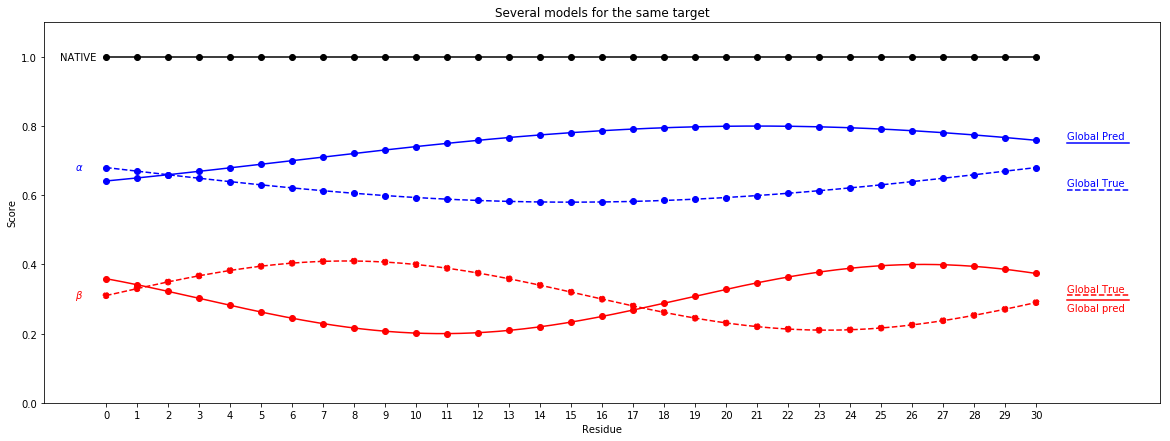

In [12]:
length = 31
x = np.linspace(0, length-1, num=1000)
sequence = np.arange(0., length)

model_native = lambda seq: np.ones_like(seq)

model_beta_true = lambda seq: .31 + .1 * np.sin(seq * (2 * np.pi / length))
model_beta_pred = lambda seq: .3  + .1 * np.sin(seq * (2 * np.pi / length) + .8 * np.pi)

model_alpha_true = lambda seq: .68 - .1 * np.sin(seq * (np.pi / (length - 1)))
model_alpha_pred = lambda seq: .7  - .1 * np.sin(seq * (np.pi / (length - 1)) + .8 * np.pi)

fig, ax = plt.subplots(1, 1, figsize=(20, 7))

ax.set_title('Several models for the same target')
ax.set_ylabel('Score')
ax.set_xlabel('Residue')

ax.plot(x, model_native(x), c='k')
ax.scatter(sequence, model_native(sequence), c='k')
ax.text(-1.5, 1, 'NATIVE', verticalalignment='center', color='k')

ax.plot(x, model_alpha_true(x), c='b', linestyle='--')
ax.plot([length, length+2], 2 * [model_alpha_true(x).mean()], c='b', linestyle='--')
ax.text(length, model_alpha_true(x).mean()+.01, 'Global True', color='b')
ax.scatter(sequence, model_alpha_true(sequence), c='b')
ax.text(-1, model_alpha_true(0), r'$\alpha$', verticalalignment='center', color='b')

ax.plot(x, model_alpha_pred(x), c='b')
ax.plot([length, length+2], 2 * [model_alpha_pred(x).mean()], c='b')
ax.text(length, model_alpha_pred(x).mean()+.01, 'Global Pred', color='b')
ax.scatter(sequence, model_alpha_pred(sequence), c='b')

ax.plot(x, model_beta_true(x), c='r', linestyle='--')
ax.plot([length, length+2], 2 * [model_beta_true(x).mean()], c='r', linestyle='--')
ax.text(length, model_beta_true(x).mean()+.01, 'Global True', color='r')
ax.scatter(sequence, model_beta_true(sequence), c='r', linestyle='--')
ax.text(-1, model_beta_true(0), r'$\beta$', verticalalignment='center', color='r')

ax.plot(x, model_beta_pred(x), c='r')
ax.plot([length, length+2], 2 * [model_beta_pred(x).mean()], c='r')
ax.text(length, model_beta_pred(x).mean()-.01, 'Global pred', color='r', verticalalignment='top')
ax.scatter(sequence, model_beta_pred(sequence), c='r')

ax.set_ylim([0, 1.1])
ax.set_xlim([-2, length+3])
ax.set_xticks(sequence);

- If we put all local scores in a scatter plot and compute the Pearson correlation coefficient between all of them we get 0.84 which is quite good
- However, if we compute the correlation coefficient at the model level and then average across the models we get -0.67 which is quite bad

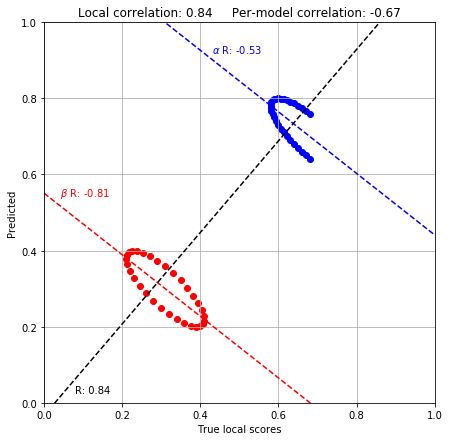

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.scatter(model_alpha_true(sequence), model_alpha_pred(sequence), c='b')
slope, intercept, pearsonr_alpha, _, _ = scipy.stats.linregress(
    model_alpha_true(sequence),
    model_alpha_pred(sequence)
)
ax.plot([0, 1], [intercept, slope + intercept], c='b', linestyle='--')
ax.text(.43, slope * .41 + intercept, f'$\\alpha$ R: {pearsonr_alpha:.2f}', color='b')

ax.scatter(model_beta_true(sequence), model_beta_pred(sequence), c='r')
slope, intercept, pearsonr_beta, _, _ = scipy.stats.linregress(
    model_beta_true(sequence),
    model_beta_pred(sequence)
)
ax.plot([0, 1], [intercept, slope + intercept], c='r', linestyle='--')
ax.text(.04, slope * .01 + intercept, f'$\\beta$ R: {pearsonr_beta:.2f}', color='r')

slope, intercept, pearsonr, _, _ = scipy.stats.linregress(
    np.concatenate((model_alpha_true(sequence), model_beta_true(sequence))),
    np.concatenate((model_alpha_pred(sequence), model_beta_pred(sequence)))
)
ax.plot([0, 1], [intercept, slope + intercept], c='k', linestyle='--')
ax.text(.08, slope * .05 + intercept, f'R: {pearsonr:.2f}', color='k')

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('True local scores')
ax.set_ylabel('Predicted')
ax.set_title(f'Local correlation: {pearsonr:.2f}     Per-model correlation: {np.mean([pearsonr_alpha, pearsonr_beta]):.2f}')
ax.grid()

## Global scores
Here we just use the average of the local scores as a global quality score.

In [14]:
def global_score(model_df):
    # Set to 0 the score of the residues not present in the model
    model_df.loc[~model_df[('Present', 'Model')], 'Score'] = 0
    # Average the scores of all remaining residues
    return model_df[['Score']].mean()

global_df = df.groupby(axis='index', level=['Target', 'Model']).apply(global_score)
display(global_df.round(2))

Score      
              Predicted  Real
Target Model                 
T001   NATIVE      0.87  1.00
       alpha       0.13  0.17
       beta        0.67  0.70
T002   NATIVE      0.52  0.80
       alpha       0.46  0.70
       beta        0.22  0.22

### Global correlation
Just take the predicted and true values for all local scores and compute R.

In [15]:
r_global = nanpearsonr(global_df.Score.Real, global_df.Score.Predicted)
print('Global correlation:', r_global)

Global correlation: 0.9428102582463254


### Per target correlation
Compute a correlation coefficient for each target (between the true and predicted global scores of all decoys) and then take the average.

```AVG ( Pearson(predicted,true) GROUPBY(Target) )```

In [16]:
groups = global_df.groupby(axis='index', level=['Target'])

for name, df_target in groups:
    display(df_target.Score.round(3))
    display(Markdown(f'Per target correlation: {nanpearsonr(df_target.Score.Real, df_target.Score.Predicted)}'))

Predicted   Real
Target Model                   
T001   NATIVE      0.867  1.000
       alpha       0.133  0.167
       beta        0.667  0.700

Per target correlation: 0.9953597034211037

Predicted   Real
Target Model                   
T002   NATIVE       0.52  0.800
       alpha        0.46  0.700
       beta         0.22  0.225

Per target correlation: 0.9996451593714057

In [17]:
r_per_target = groups.apply(lambda df_target: nanpearsonr(df_target.Score.Real, df_target.Score.Predicted))
display(r_per_target.to_frame('R per target').round(3))

avg_r_per_target = r_per_target.mean()
print('Per target correlation:', avg_r_per_target)

,R per target
Target,
T001,0.995
T002,1.000


Per target correlation: 0.9975024313962547


## Pearson R vs R2 vs RMSE

Is Pearson R the best metric to optimize for? Yes, if we just care about correlation and we have enough data points.

In [18]:
def correlation_plot(x, y, ax):
    ax.scatter(x, y, marker='.', alpha=.2 if len(x) > 10 else 1.)
    ax.set_title(f'R: {nanpearsonr(x, y):.2f}   '
                 f'$R^2$: {r2_score(x, y):.2f}   '
                 f'RMSE: {np.sqrt((x-y) ** 2).mean():.2f}')
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

### Correlated but not identical values

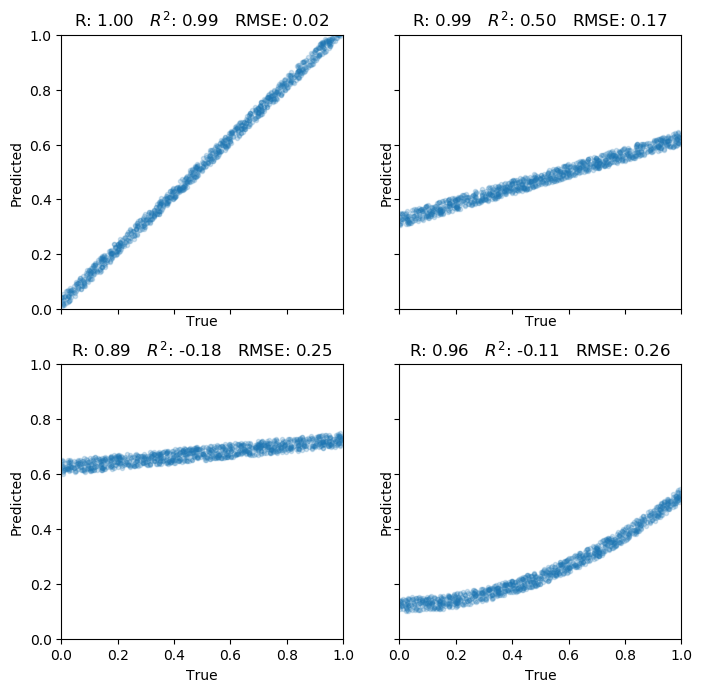

In [19]:
N = 1000
x = np.random.rand(N)

fig, axes = plt.subplots(2, 2, figsize=(8, 8), dpi=100, sharex=True, sharey=True)

y = x + .05 * np.random.rand(N)
correlation_plot(x, y, ax=axes.flat[0])

y = .3 * x + .3 + .05 * np.random.rand(N)
correlation_plot(x, y, ax=axes.flat[1])

y = .1 * x + .6 + .05 * np.random.rand(N)
correlation_plot(x, y, ax=axes.flat[2])

y = .4 * x ** 2 + .1 + .05 * np.random.rand(N)
correlation_plot(x, y, ax=axes.flat[3])

### Constant array(s)

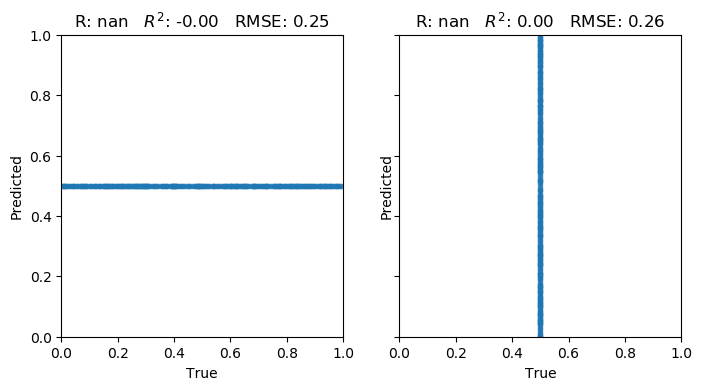

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=100, sharex=True, sharey=True)

x = np.random.rand(N)
y = .5 * np.ones(N)
correlation_plot(x, y, ax=axes.flat[0])

x = .5 * np.ones(N)
y = np.random.rand(N)
correlation_plot(x, y, ax=axes.flat[1])

### Very few data points

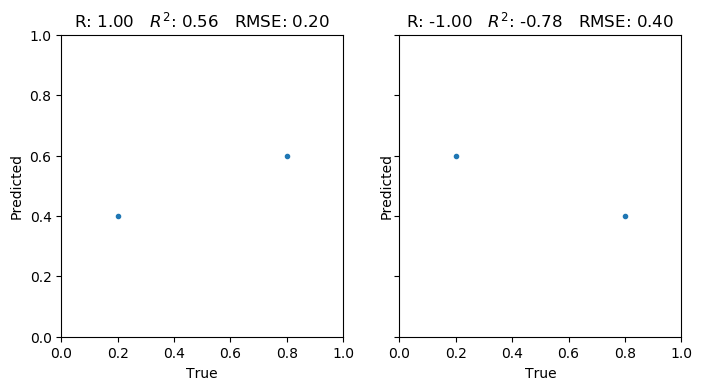

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=100, sharex=True, sharey=True)

x = np.array([.2, .8])
y = np.array([.4, .6])
correlation_plot(x, y, ax=axes.flat[0])

x = np.array([.2, .8])
y = np.array([.6, .4])
correlation_plot(x, y, ax=axes.flat[1])